In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf

import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from moles import MolesConfig
from moles import MolesDataset

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from mrcnn.visualize import display_images

from moles_large import MolesConfig
from moles_large import MolesDataset
from moles_large import BalancedDataset
from moles_large import MolesDatasetFast
from moles_large import ISIC17Dataset
from moles_large import ISIC17AugDataset

from sklearn.metrics import confusion_matrix, auc, classification_report, accuracy_score, precision_recall_curve, roc_auc_score, jaccard_score

/home/lunet/couj/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/lunet/couj/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/lunet/couj/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/lunet/couj/anaconda3/envs/tf/lib/python3

In [2]:
ROOT_DIR = os.path.abspath("./")
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
metrics_file_path = os.path.join(MODEL_DIR, "metrics17")

In [3]:
config = MolesConfig()

In [4]:
#dataset_train = ISIC17AugDataset()
#dataset_train.load_moles("data/large/train/")

dataset_train = ISIC17Dataset()
dataset_train.load_moles("data/large/train_o/")

dataset_train.prepare()
ds = dataset_train

dataset_val = ISIC17AugDataset()
dataset_val.load_moles("data/large/val")
dataset_val.prepare()

dataset_test = ISIC17AugDataset()
dataset_test.load_moles("data/large/test")
dataset_test.prepare()

In [5]:
dataset_train = ISIC17Dataset()
dataset_train.load_moles("data/large/train_o/")

dataset_train.prepare()
ds = dataset_train

In [6]:
class InferenceConfig(MolesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.01
    MEAN_PIXEL = np.array([123.7, 116.8, 103.9])

inference_config = InferenceConfig()

def get_metrics(y,y_pred):

    if type(y) == type([]):
        y = np.array(y)

    if type(y_pred) == type([]):
        y_pred = np.array(y_pred)
        
    #tp, fp, fn, tn = confusion_matrix(y,y_pred).ravel()
    metrics = {}
    metrics["acc"] = (((y_pred) == y).sum()/len(y)) #Accuracy
    try:
        metrics["auc"] = roc_auc_score(y,y_pred) # AUC
    except ValueError:
        metrics["auc"] = 0
    #metrics["sensitivity"] = (tp/(tp+fn))#sensitivity
    #metrics["specificity"] = (tn/(tn+fp))#specificity
    #metrics.append(tp/(tp+fn))#tpr
    #metrics.append(fp/(fp+tn))#fpr

    return metrics

def eval_model(model, dataset):
    image_ids = dataset.image_ids

    APs = []
    Ps = []
    Rs = []
    preds = []
    gts = []
    ious = [] 

    for image_id in tqdm(image_ids):
        # Load image and ground truth data
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, inference_config,
                                image_id, use_mini_mask=False)

        # Run object detection
        results = model.detect([image], verbose=0)
        r = results[0]
        # Compute AP
    
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, [gt_class_id], gt_mask,
                            r["rois"], r["class_ids"], r["scores"], r['masks'])
        
        APs.append(AP)
        Ps.append(precisions)
        Rs.append(recalls)
        gts.append(gt_class_id[0])
        if len(r["scores"]) != 0:
            preds.append(r["class_ids"][r["scores"].argmax()])
            pred_mask = r["masks"][:,:,r["scores"].argmax()]
            js = jaccard_score(gt_mask.flatten(), pred_mask.flatten())
            ious.append(js)
        else:
            preds.append(-1)
            ious.append(0)
    
    return APs, ious, preds, gts 

In [7]:
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


In [8]:
model_path = "logs/moles20200810T1408/mask_rcnn_moles_0156.h5"
#model_path = "logs/moles11/mask_rcnn_moles_0337.h5"
model.load_weights(model_path, by_name=True)

Re-starting from epoch 156


In [9]:
# Validation Set
(APs, IoUs_v, preds_v, gts_v) = eval_model(model, dataset_val)
df_v = pd.DataFrame({"gts": gts_v, "preds": preds_v, "ji": IoUs_v})

100%|██████████| 150/150 [02:26<00:00,  1.02it/s]


In [16]:
# Triaining Set
(APs, IoUs_t, preds_t, gts_t) = eval_model(model, dataset_train)
df_t = pd.DataFrame({"gts": gts_t, "preds": preds_t, "ji": IoUs_t})

100%|██████████| 2000/2000 [07:01<00:00,  4.75it/s]


In [10]:
# Test Set
(APs, IoUs_tst, preds_tst, gts_tst) = eval_model(model, dataset_test)
df_tst = pd.DataFrame({"gts": gts_tst, "preds": preds_tst, "ji": IoUs_tst})

100%|██████████| 600/600 [14:10<00:00,  1.42s/it]


In [11]:
def print_counts(df):
    print(df["gts"].value_counts())
    print(df["preds"].value_counts())

def print_wrong(df):
    df_wrong = df[df["gts"] != df["preds"]]
    print(df_wrong["gts"].value_counts())
    print(df_wrong["preds"].value_counts())
    print(len(df[df["gts"] != df["preds"]]))
    
def model_complete_performance(df, IoUs):
    mgt = [int(x == 2) for x in df["gts"]]
    mpreds = [int(x == 2) for x in df["preds"]]
    print(get_metrics(mgt,mpreds))
    
    skgt = [int(x == 3) for x in df["gts"]]
    skpreds = [int(x == 3) for x in df["preds"]]
    print(get_metrics(skgt, skpreds))
    
    print("jaccard_index: {}".format(np.mean(IoUs)))
        


In [13]:
confusion_matrix(df_v["gts"], df_v["preds"])

array([[69,  4,  5],
       [14, 13,  3],
       [ 6,  2, 34]])

In [15]:
confusion_matrix(df_tst["gts"], df_tst["preds"])

array([[  0,   0,   0,   0],
       [  3, 337,  29,  24],
       [  0,  40,  60,  17],
       [  1,  18,   7,  64]])

In [17]:
confusion_matrix(df_t["gts"], df_t["preds"])

array([[1361,    9,    2],
       [  16,  358,    0],
       [   0,    0,  254]])

In [45]:
wrong = df_tst[df_tst["gts"] != df_tst["preds"]]
wrong[wrong["gts"] == 2]

gts  preds        ji
4      2      1  0.956530
6      2      1  0.776233
9      2      3  0.866778
32     2      3  0.467778
48     2      1  0.858231
62     2      1  0.865636
78     2      1  0.895574
80     2      3  0.664408
106    2      1  0.853028
112    2      3  0.509984
150    2      3  0.826791
156    2      1  0.865510
160    2      1  0.817490
170    2      1  0.919029
185    2      3  0.608699
204    2      1  0.893048
207    2      1  0.894995
211    2      1  0.509365
214    2      3  0.925422
219    2      1  0.754784
221    2      3  0.836743
223    2      1  0.752967
225    2      1  0.477433
226    2      1  0.544342
236    2      3  0.895452
245    2      1  0.754470
259    2      1  0.955253
270    2      1  0.588838
279    2      1  0.809620
286    2      3  0.674394
290    2      3  0.840749
311    2      1  0.941261
323    2      3  0.761574
324    2      1  0.911472
343    2      1  0.887100
355    2      1  0.915719
362    2      1  0.823378
364    2      3  0.900631
376    2      3  0.108081
380    2      1  0.841614
387    2      1  0.860374
409    2      1  0.367038
418    2      1  0.348800
428    2      1  0.054051
434    2      1  0.916553
436    2      1  0.845302
442    2      1  0.458219
452    2      1  0.851402
457    2      3  0.768962
461    2      1  0.000000
482    2      1  0.935770
484    2      1  0.749588
517    2      1  0.795470
552    2      1  0.532217
592    2      3  0.886627
597    2      1  0.898686
599    2      3  0.804434

(-0.5, 511.5, 511.5, -0.5)

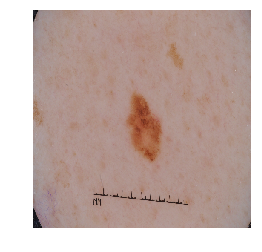

In [59]:
plt.imshow(dataset_test.load_image(image_ids[5]))
plt.axis("off")

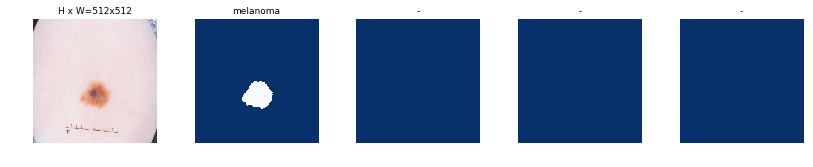

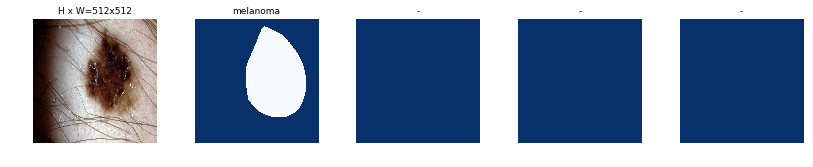

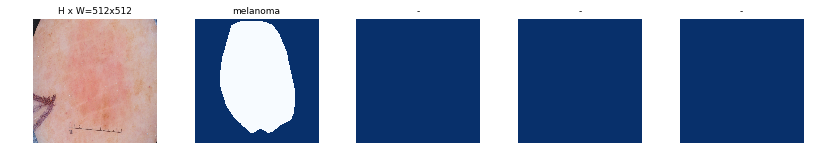

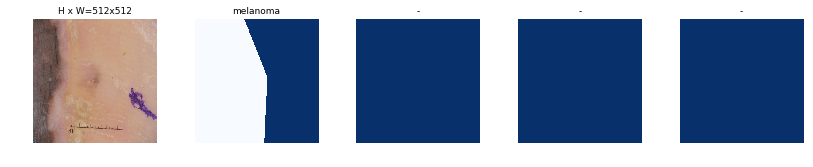

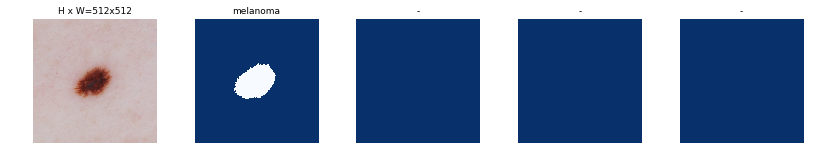

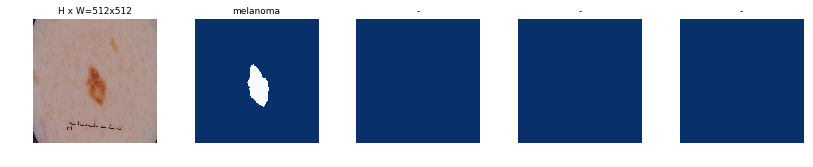

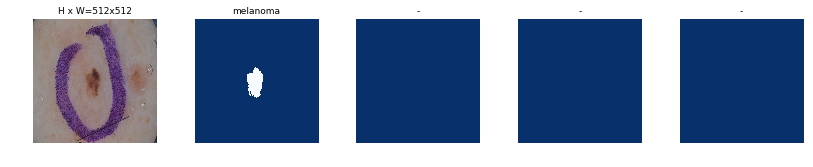

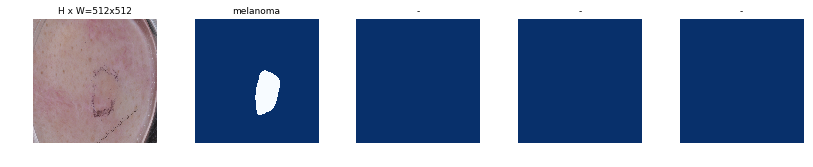

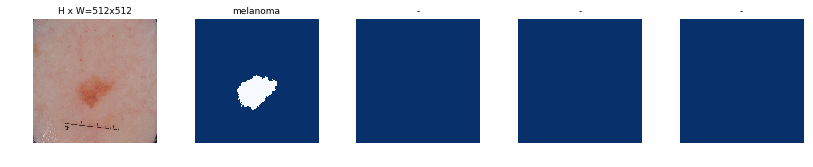

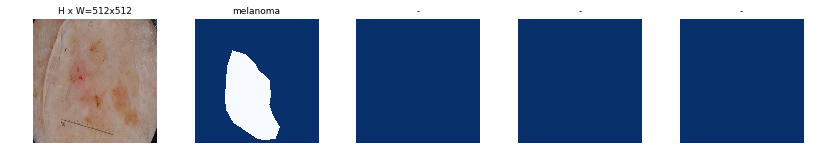

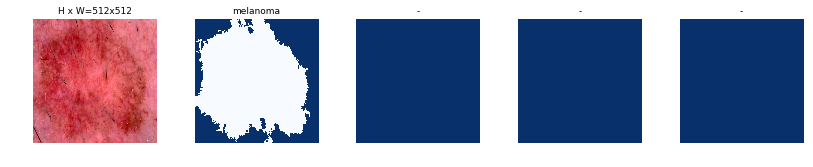

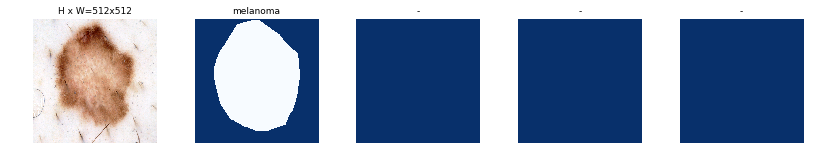

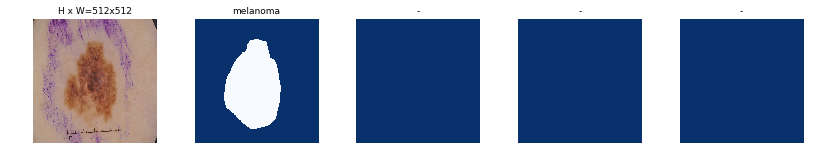

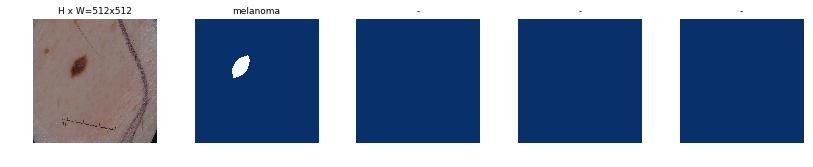

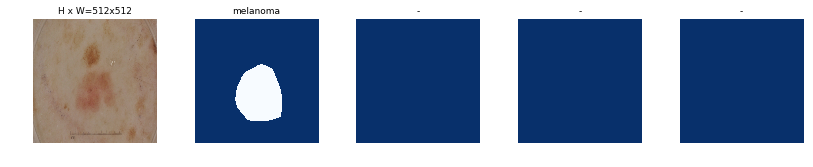

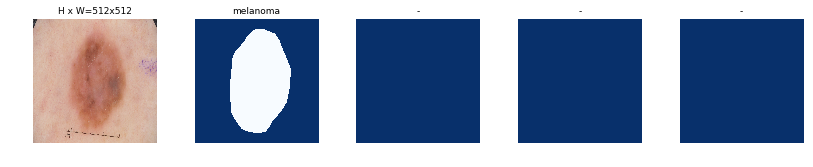

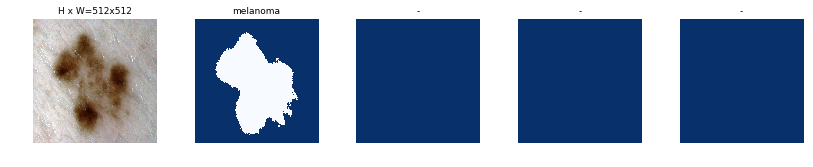

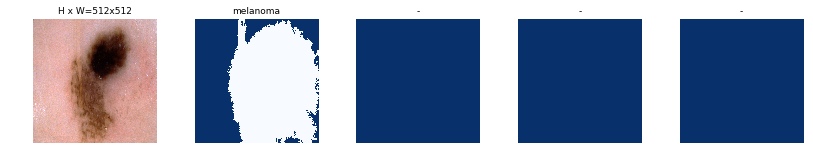

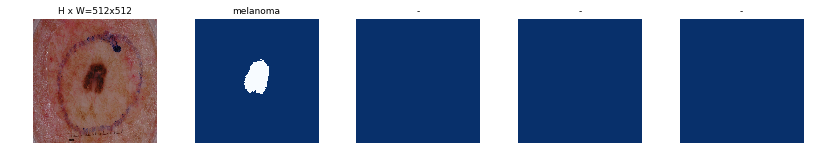

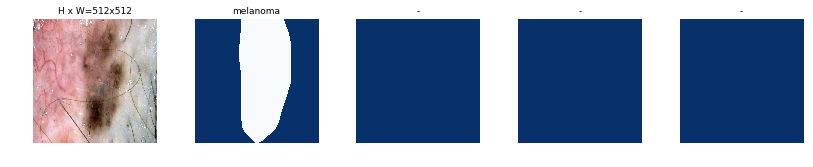

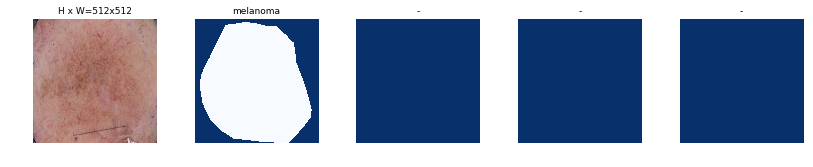

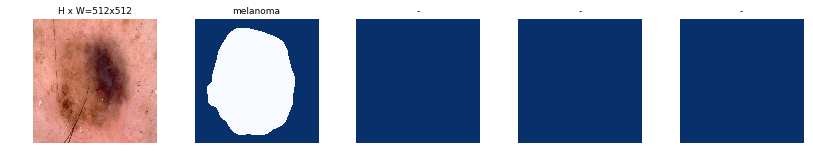

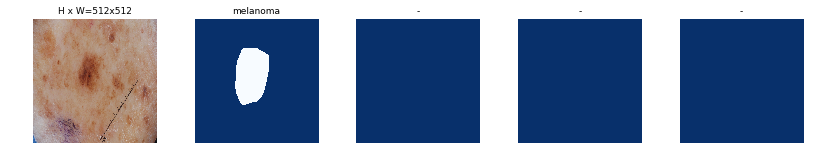

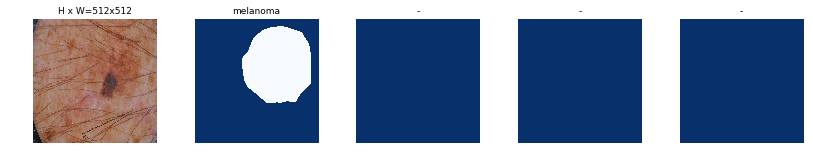

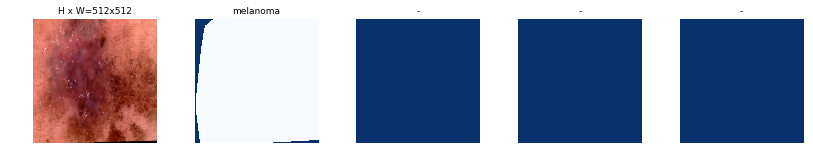

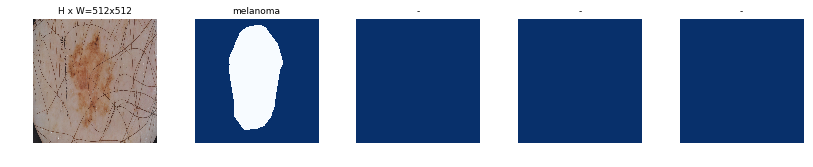

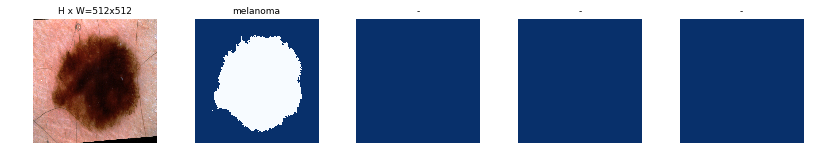

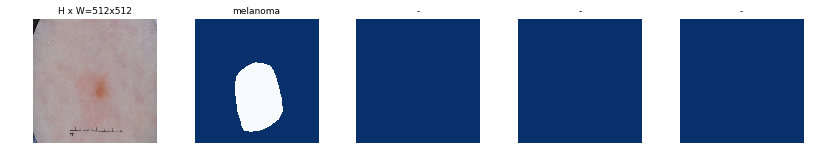

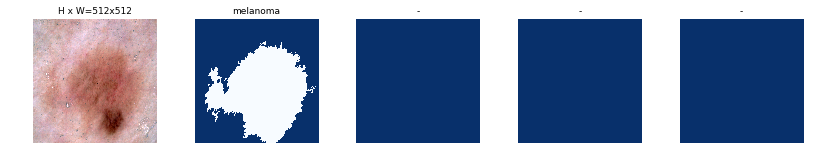

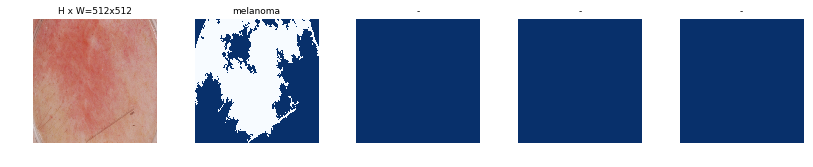

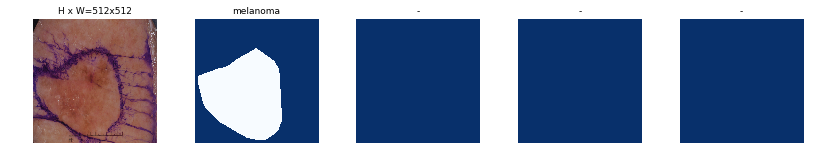

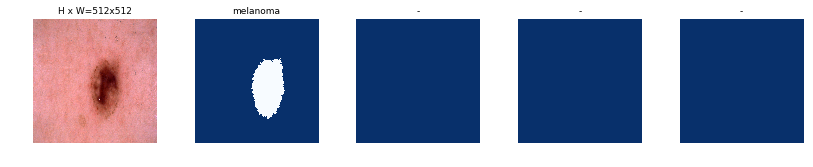

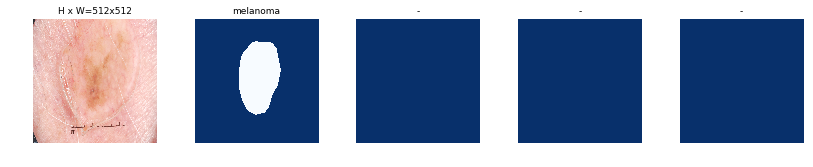

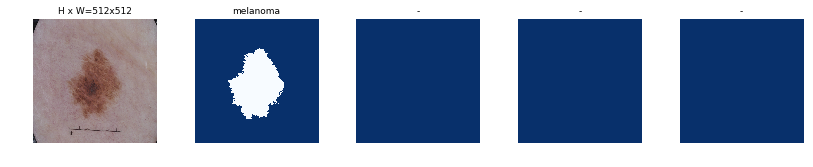

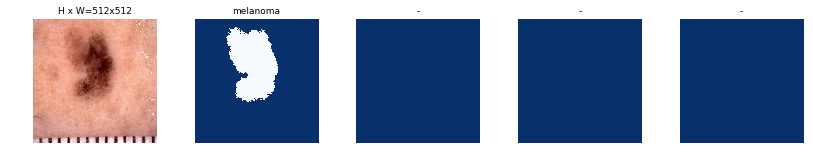

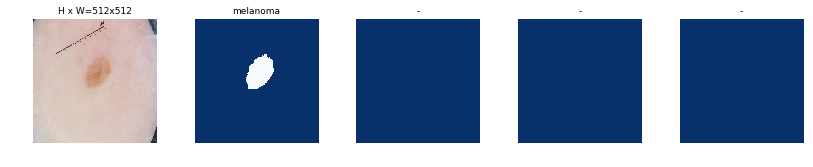

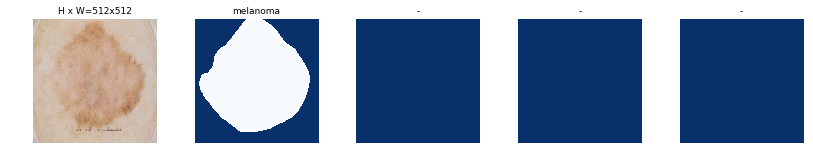

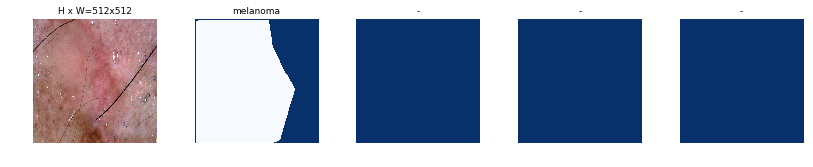

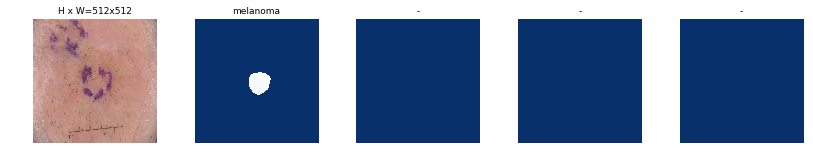

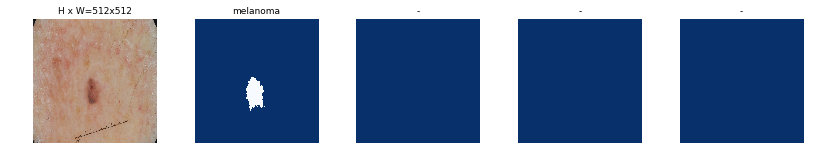

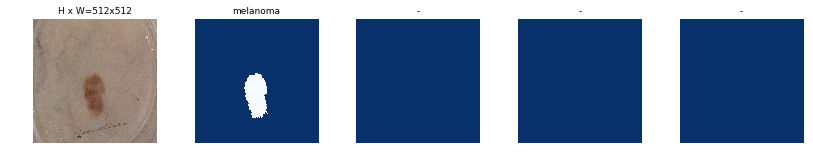

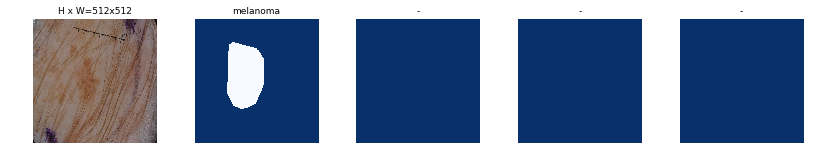

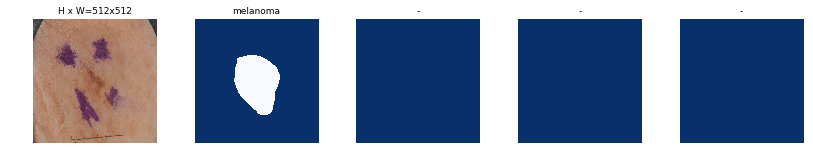

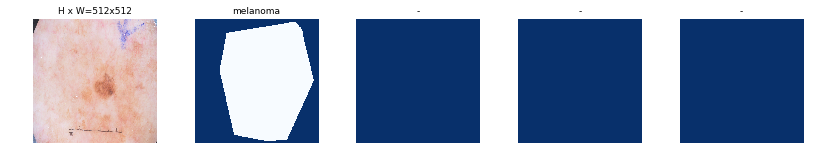

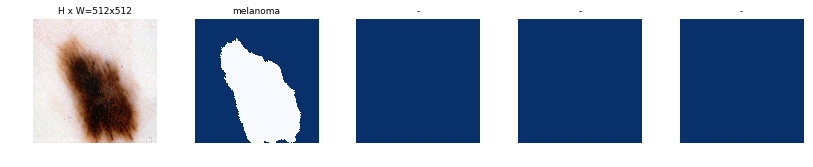

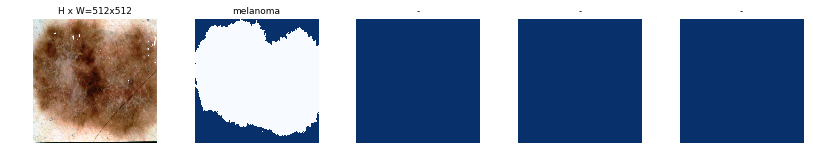

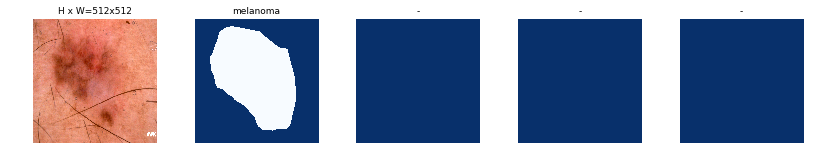

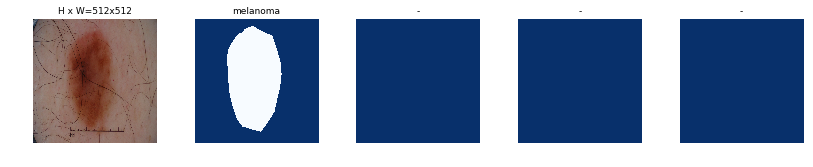

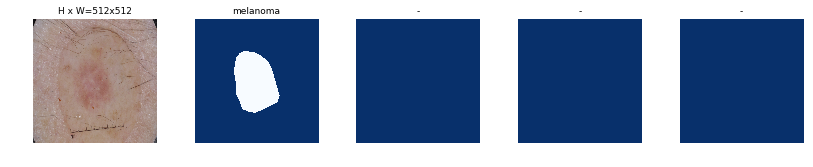

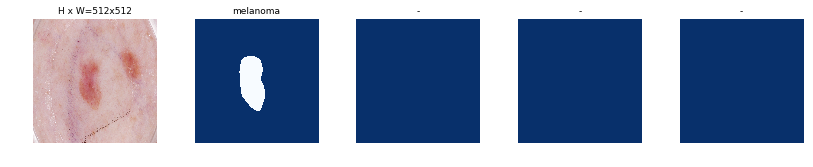

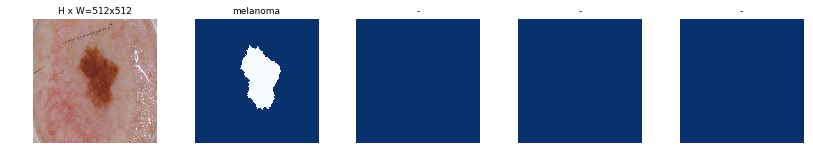

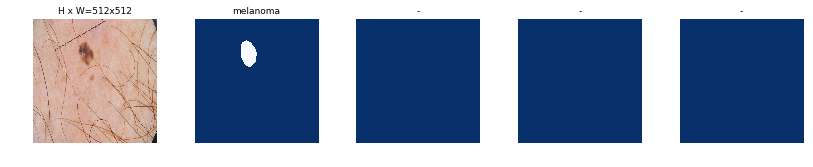

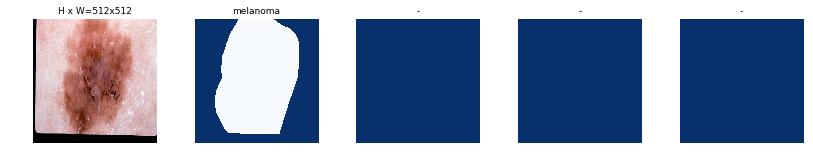

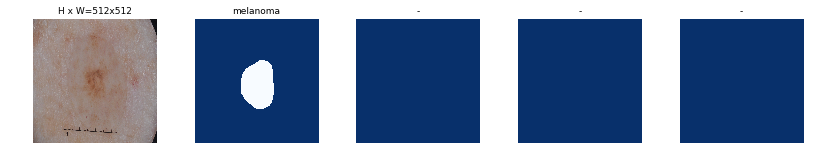

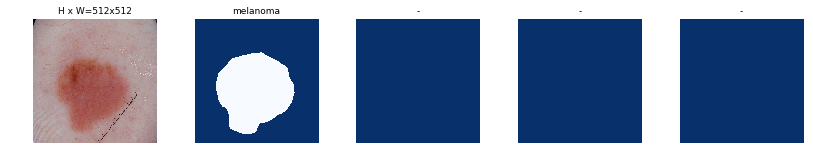

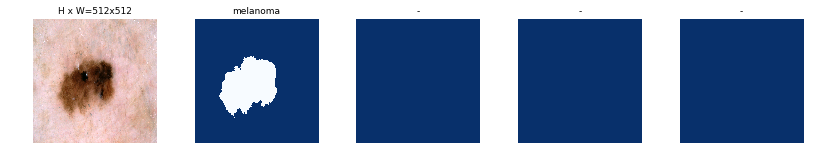

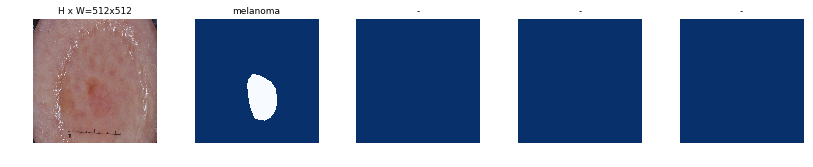

In [56]:
wrong = df_tst[df_tst["gts"] != df_tst["preds"]]
wrong[wrong["gts"] == 2]

ds = dataset_test
image_ids = wrong[wrong["gts"] == 2].index
for image_id in image_ids:
    image = ds.load_image(image_id)
    mask, class_ids = ds.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, ds.class_names)

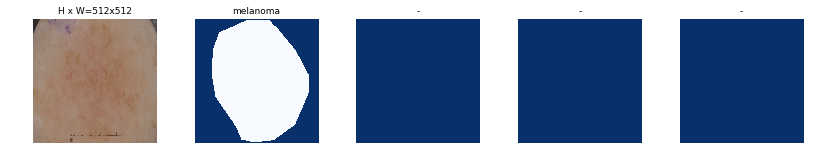

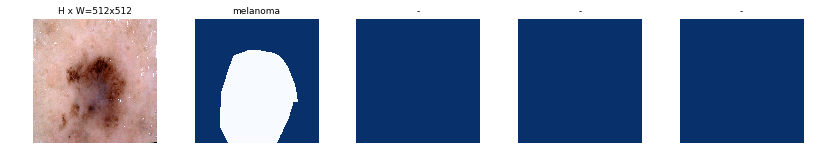

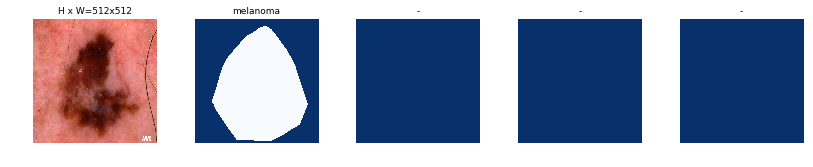

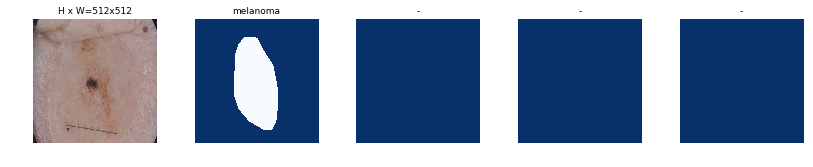

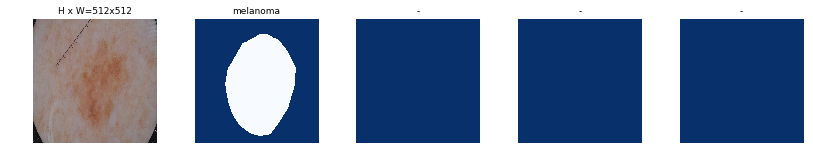

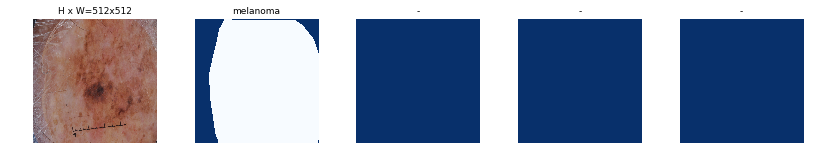

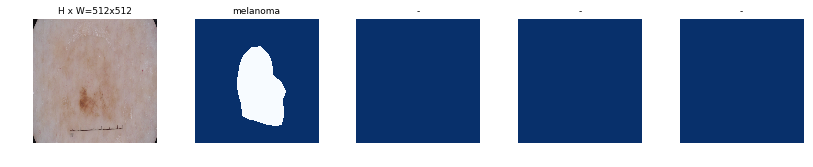

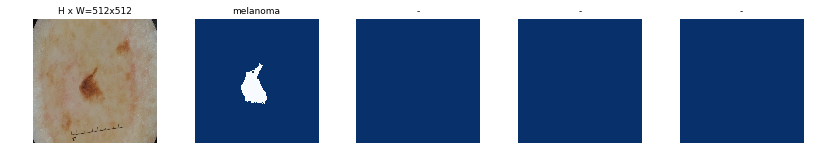

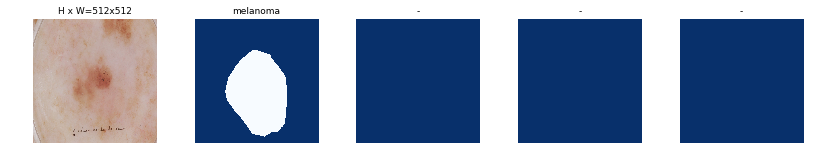

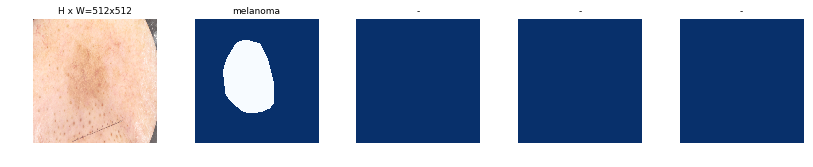

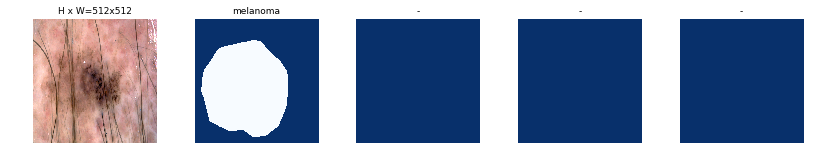

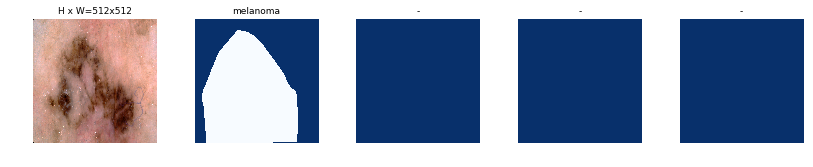

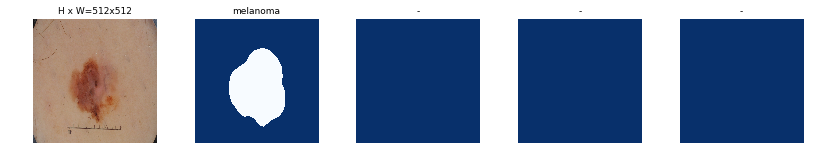

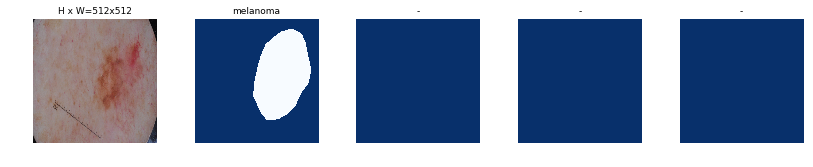

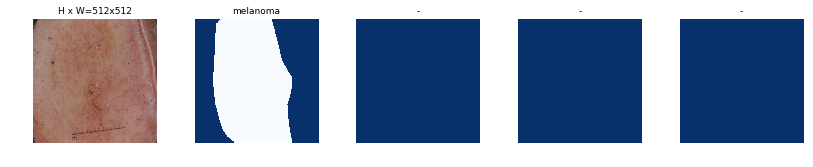

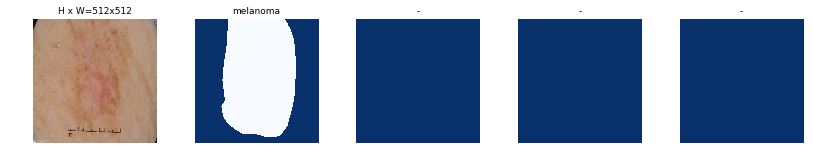

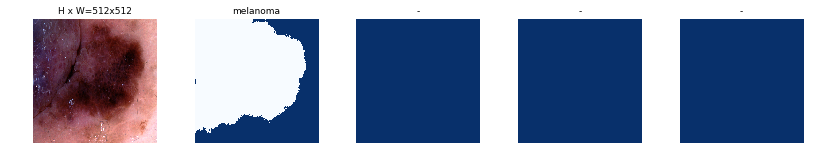

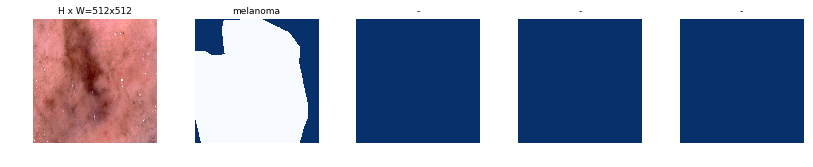

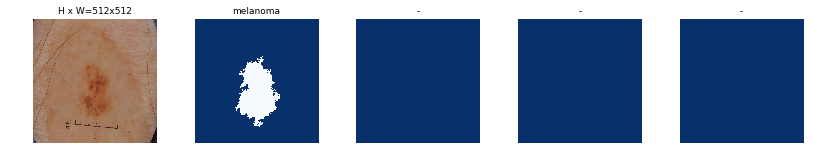

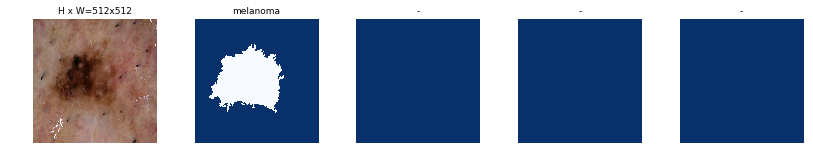

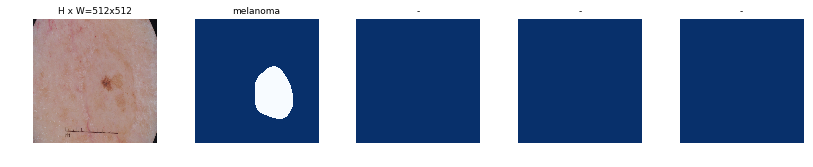

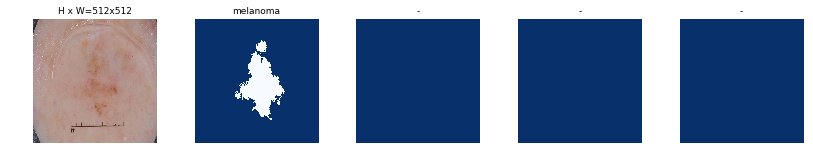

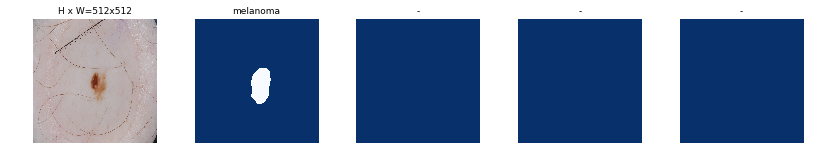

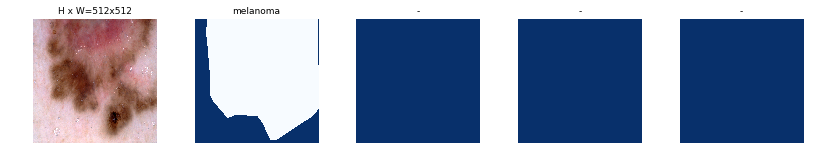

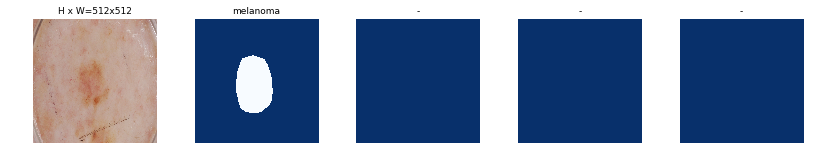

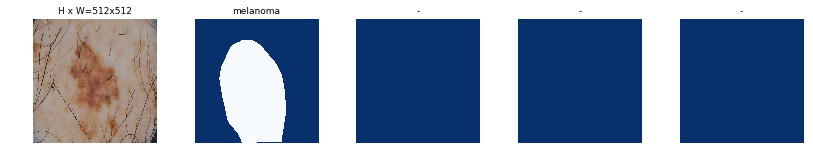

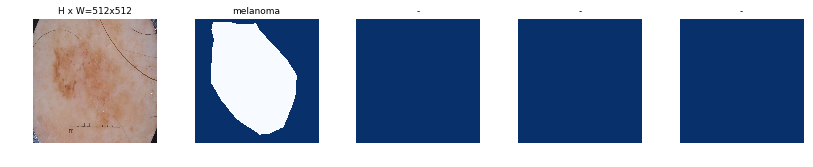

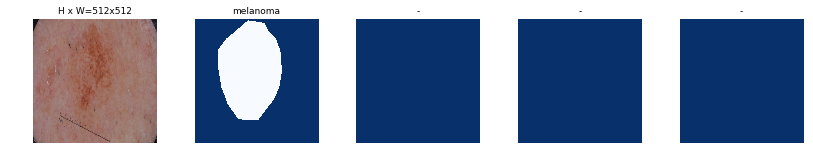

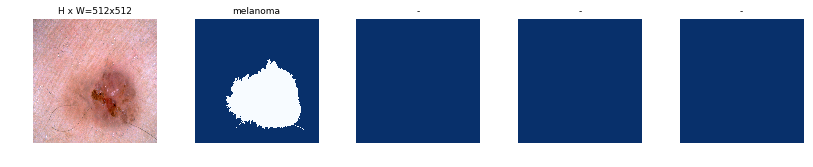

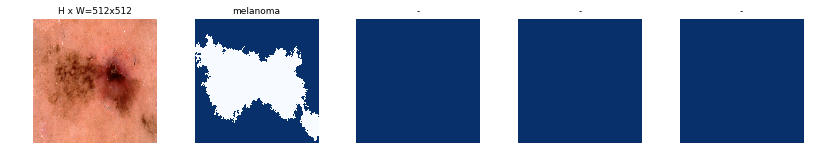

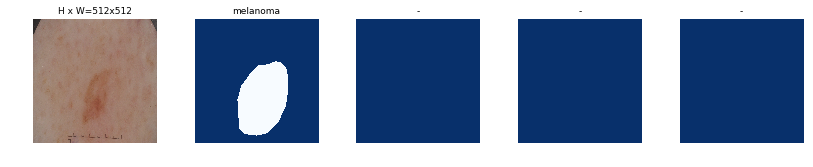

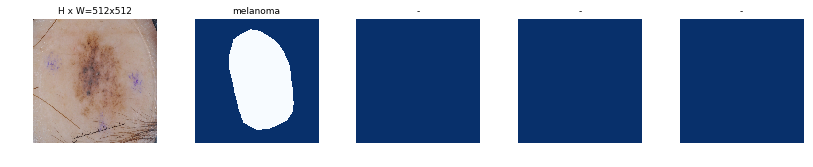

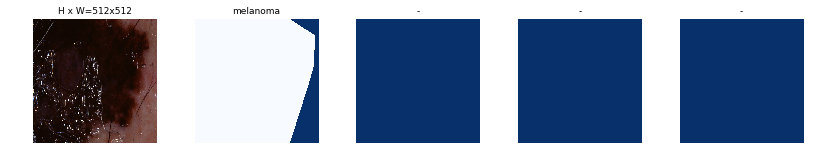

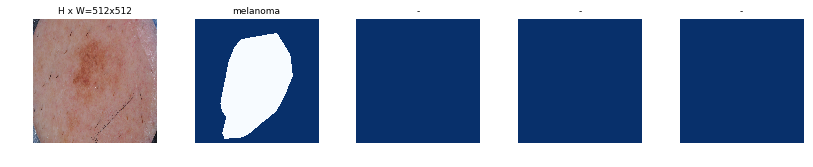

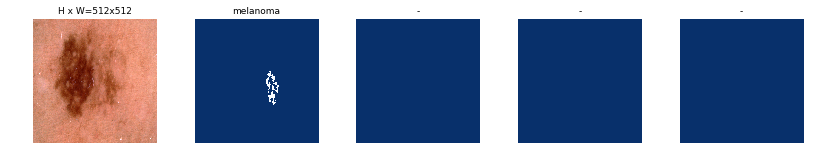

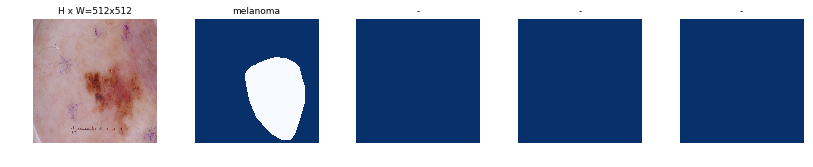

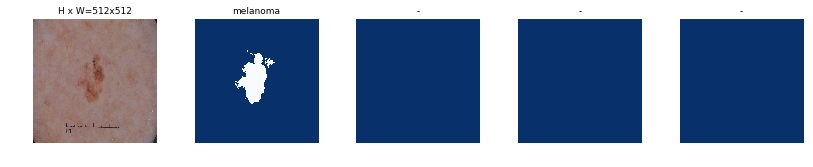

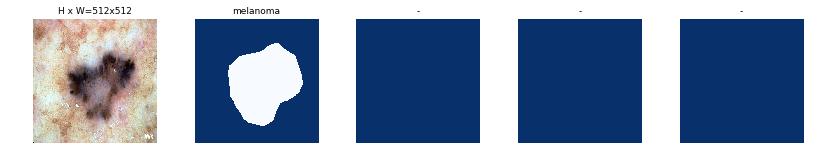

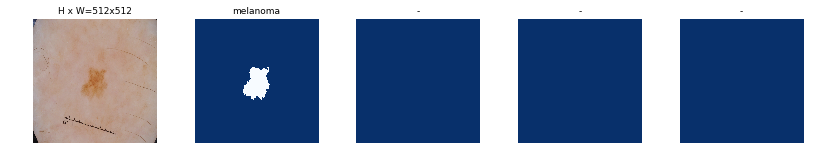

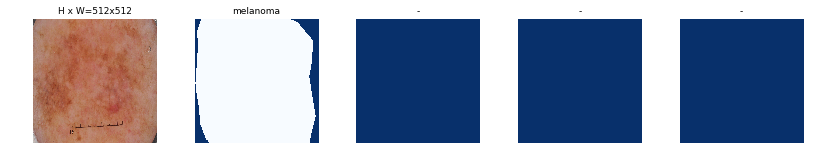

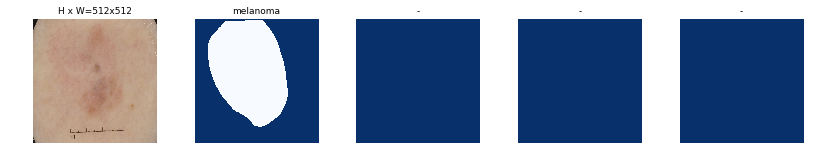

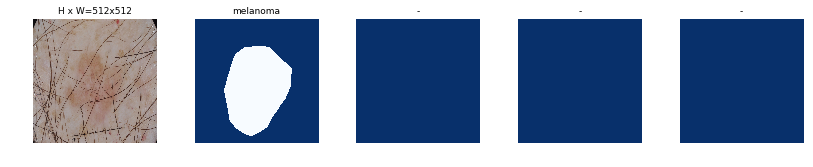

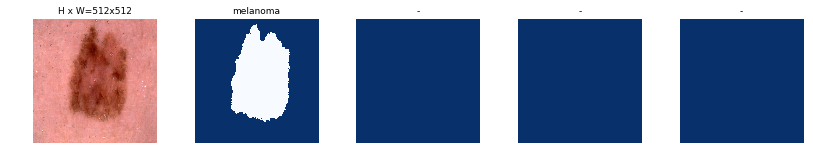

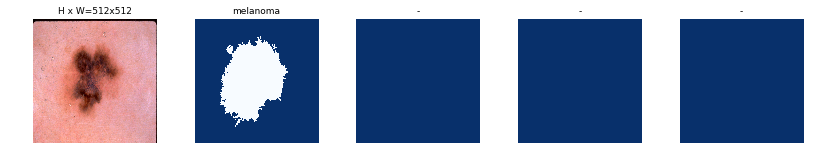

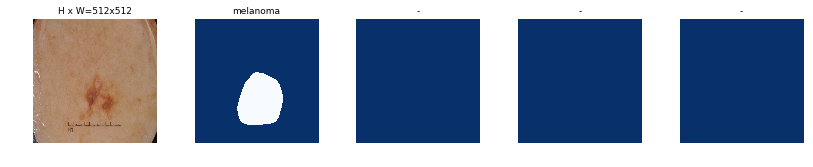

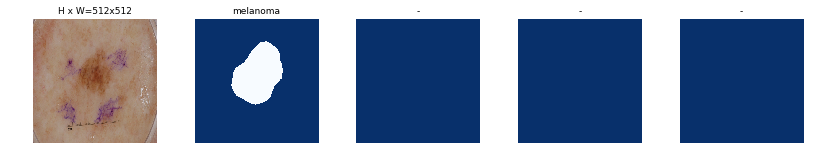

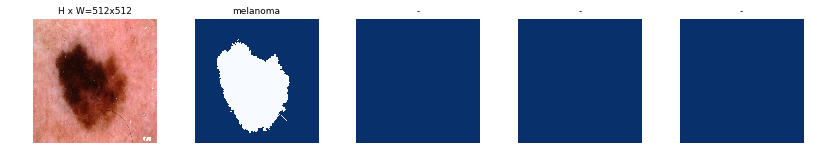

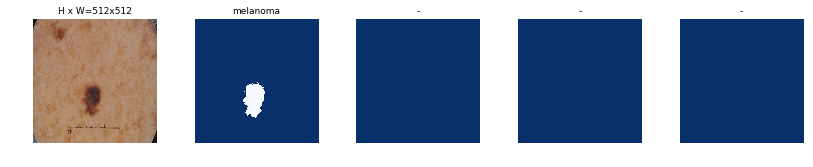

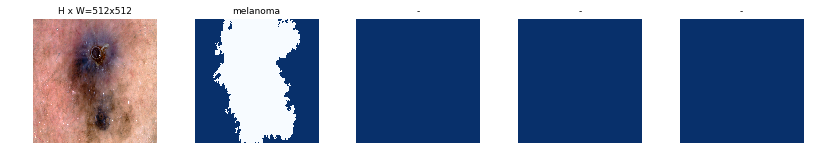

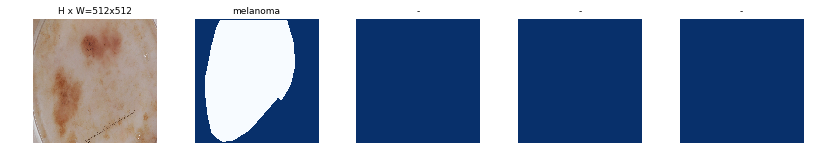

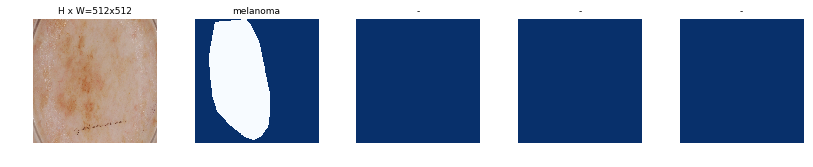

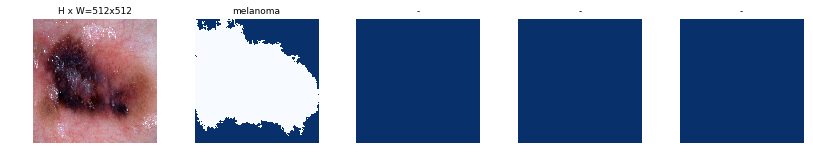

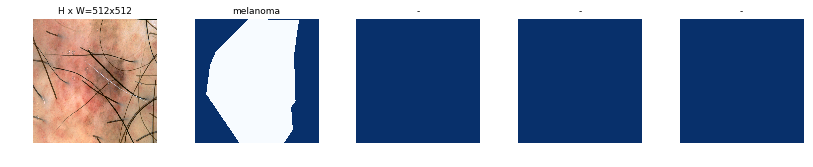

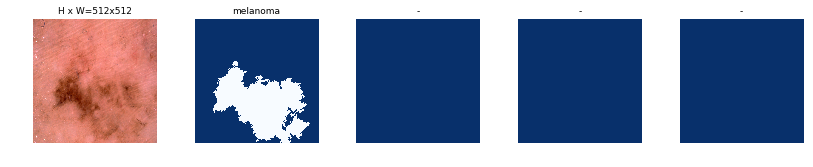

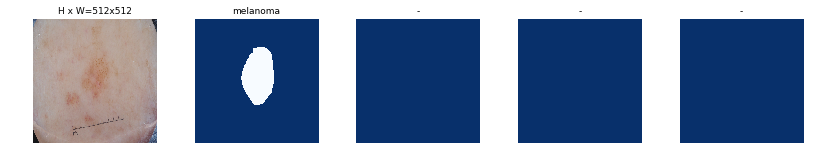

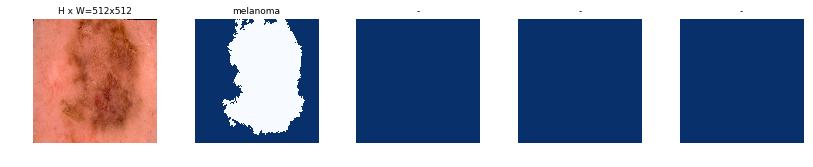

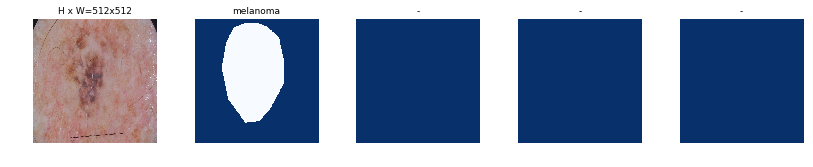

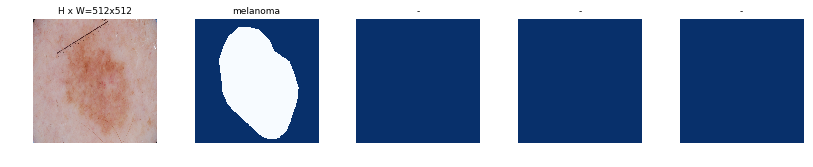

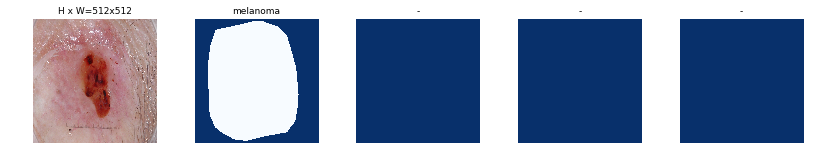

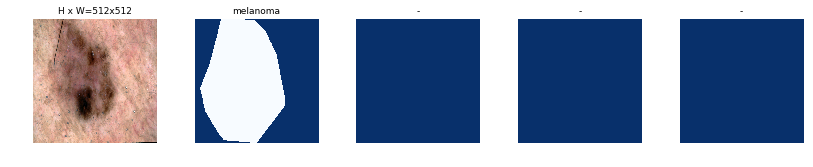

In [60]:
right = df_tst[df_tst["gts"] == df_tst["preds"]]
right[right["gts"] == 2]

ds = dataset_test
image_ids = right[right["gts"] == 2].index
for image_id in image_ids:
    image = ds.load_image(image_id)
    mask, class_ids = ds.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, ds.class_names)

data/large/train_o/images/ISIC_0009956.jpg


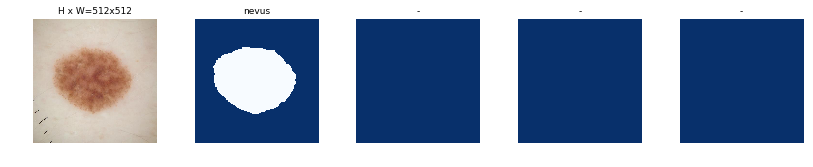

data/large/train_o/images/ISIC_0000453.jpg


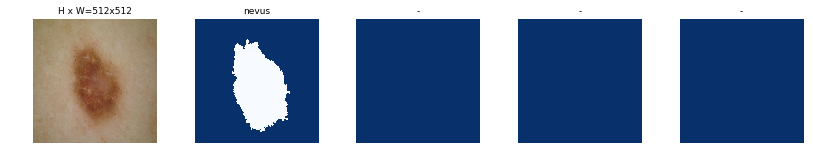

data/large/train_o/images/ISIC_0013888.jpg


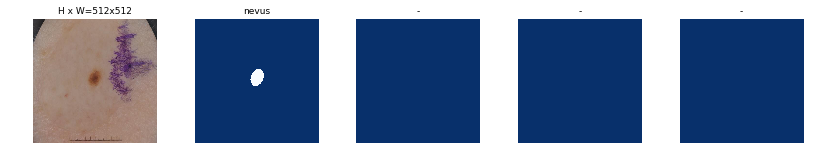

data/large/train_o/images/ISIC_0000059.jpg


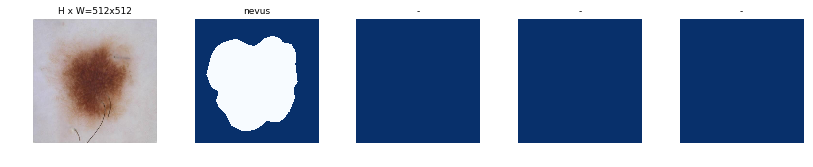

data/large/train_o/images/ISIC_0000119.jpg


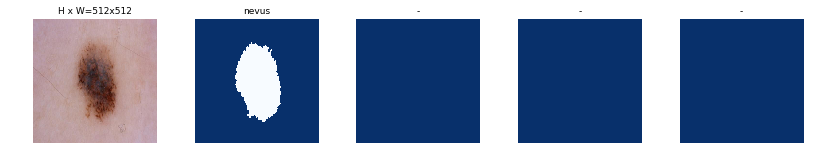

data/large/train_o/images/ISIC_0013257.jpg


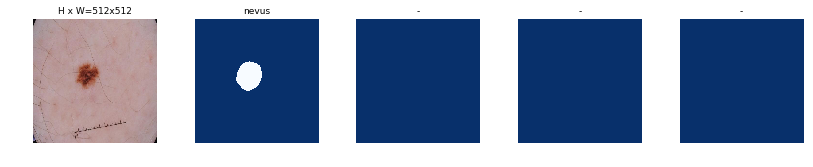

data/large/train_o/images/ISIC_0002879.jpg


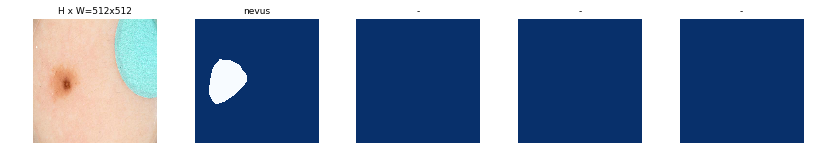

data/large/train_o/images/ISIC_0000240.jpg


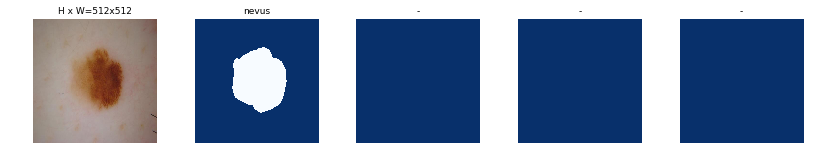

data/large/train_o/images/ISIC_0009949.jpg


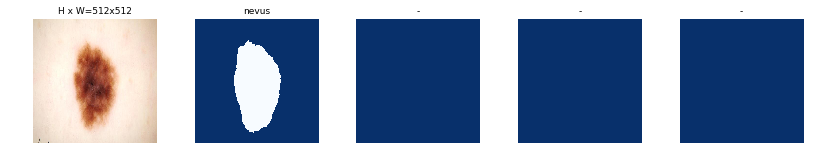

data/large/train_o/images/ISIC_0010856.jpg


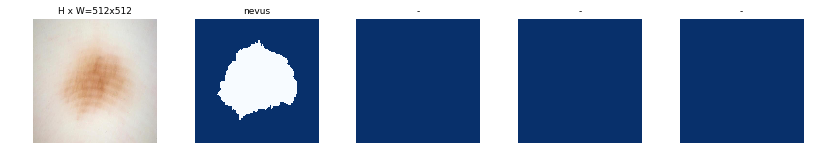

In [49]:
ds = dataset_train
image_ids = df_t[df_t["gts"] == 1].index
image_ids = np.random.choice(image_ids, 10)
for image_id in image_ids:
    image = ds.load_image(image_id)
    mask, class_ids = ds.load_mask(image_id)
    print(ds.image_info[image_id]['path'])
    visualize.display_top_masks(image, mask, class_ids, ds.class_names)

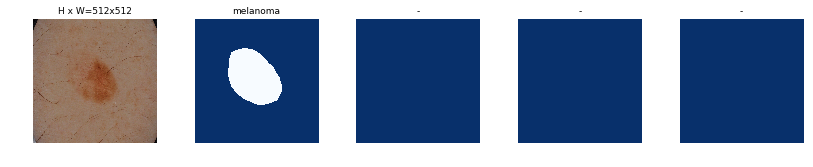

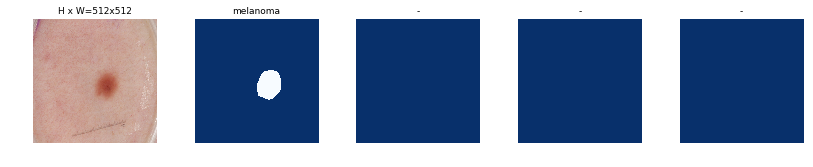

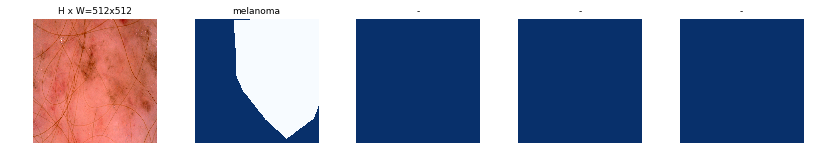

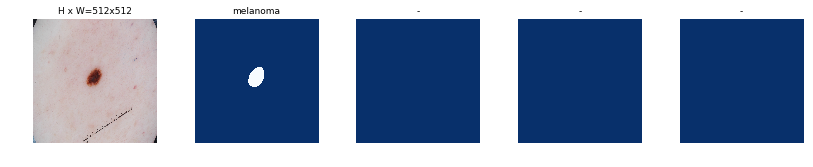

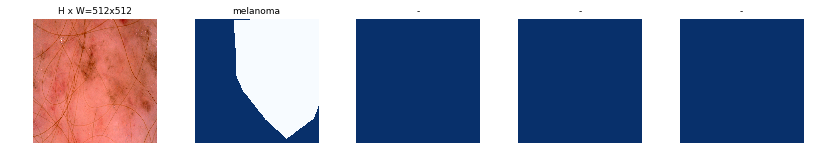

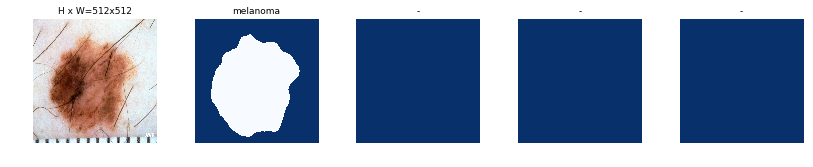

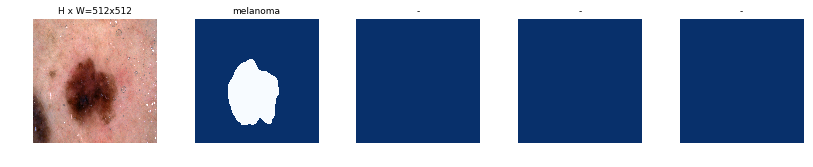

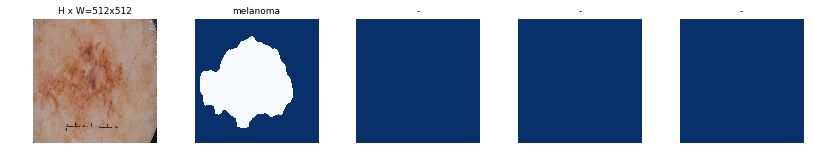

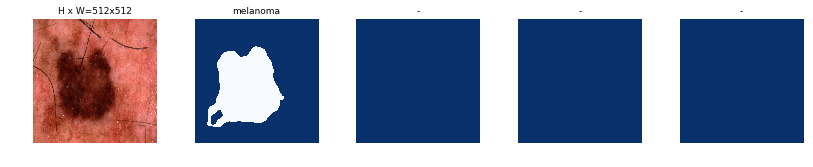

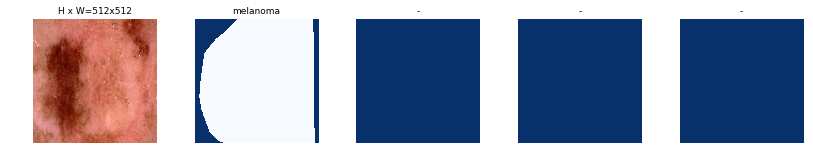

In [37]:
ds = dataset_val
image_ids = df_v[df_v["gts"] == 2].index
image_ids = np.random.choice(image_ids, 10)
for image_id in image_ids:
    image = ds.load_image(image_id)
    mask, class_ids = ds.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, ds.class_names)

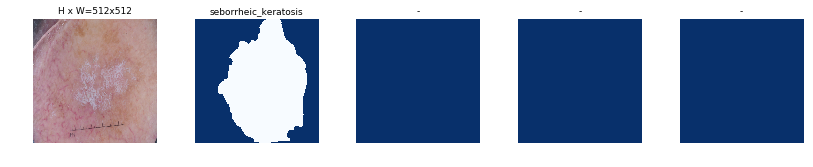

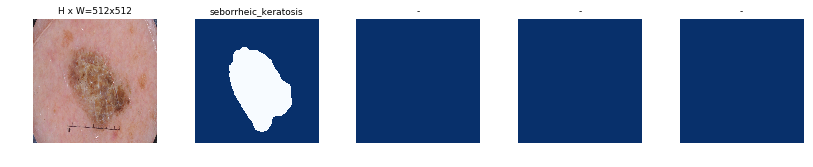

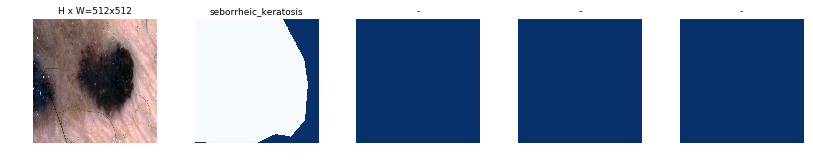

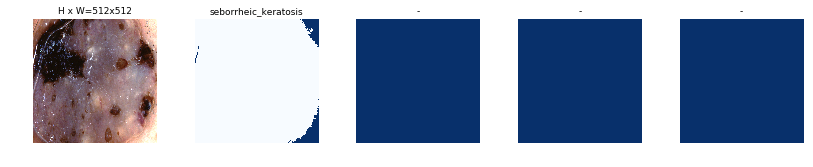

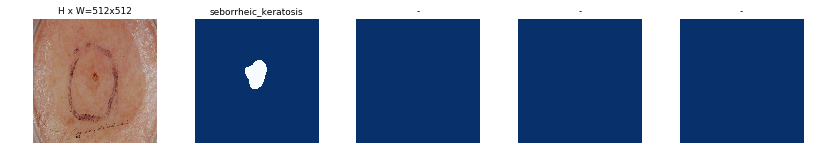

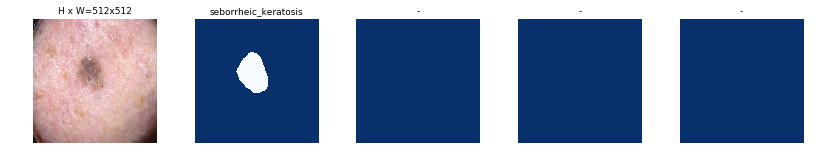

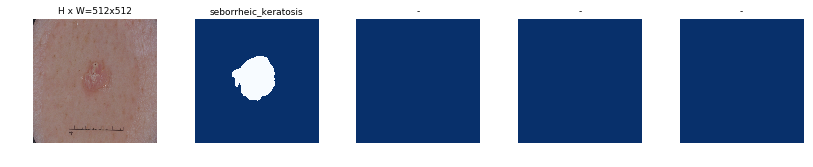

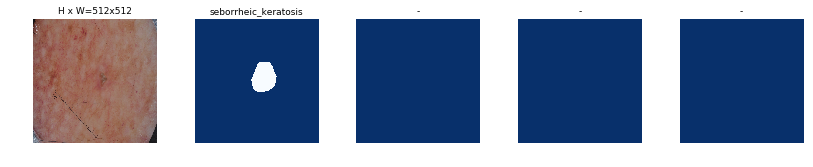

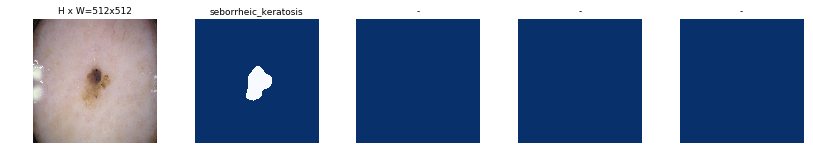

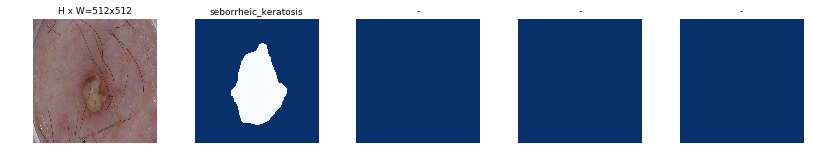

In [38]:
ds = dataset_val
image_ids = df_v[df_v["gts"] == 3].index
image_ids = np.random.choice(image_ids, 10)
for image_id in image_ids:
    image = ds.load_image(image_id)
    mask, class_ids = ds.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, ds.class_names)

In [21]:
print(df_v[df_v["gts"] == 1]["ji"].mean())
print(df_v[df_v["gts"] == 2]["ji"].mean())
print(df_v[df_v["gts"] == 3]["ji"].mean())

0.7958030291629117
0.7158535877168127
0.7040475699776594


In [22]:
print(df_tst[df_tst["gts"] == 1]["ji"].mean())
print(df_tst[df_tst["gts"] == 2]["ji"].mean())
print(df_tst[df_tst["gts"] == 3]["ji"].mean())

0.7834192230519078
0.7078793765710414
0.6814537580064037


In [102]:
print_counts(df_t)

print_wrong(df_t)

1    1372
2     374
3     254
Name: gts, dtype: int64
1    1377
2     367
3     256
Name: preds, dtype: int64
2    16
1    11
Name: gts, dtype: int64
1    16
2     9
3     2
Name: preds, dtype: int64
27


In [98]:
print(df_t[df_t["gts"] == 1]["ji"].mean())
print(df_t[df_t["gts"] == 2]["ji"].mean())
print(df_t[df_t["gts"] == 3]["ji"].mean())

0.8967959823624442
0.9085141801650374
0.9127635538032295


In [101]:
np.mean(IoUs_t)

0.9010151669245088

0.0
0.9010151669245088
0.985910098218927
      gts  preds        ji
1649    1      1  0.000000
1412    1      2  0.006768
1472    1      1  0.359478
849     1      1  0.395651
1370    1      1  0.622314
1703    1      2  0.630788
1126    1      1  0.654632
1197    1      1  0.663753
199     1      1  0.665689
1526    1      1  0.666667


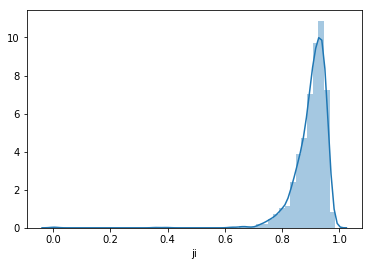

In [103]:
an_jc(df_t)

In [183]:
def an_jc(df):
    sns.distplot(df["ji"])
    print(df["ji"].min())
    print(df["ji"].mean())
    print(df["ji"].max())
    print(df.sort_values("ji").head(10))
    

0.0
0.7078793765710414
0.9565301204819278


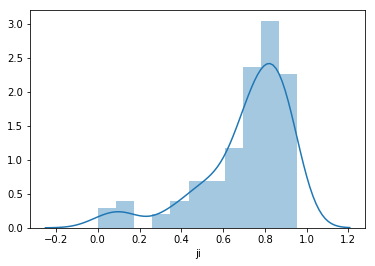

In [40]:
an_jc(df_tst[df_tst["gts"] == 2])

0.0
0.6814537580064037
0.9490274591182101


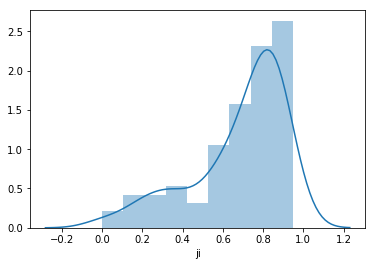

In [39]:
an_jc(df_tst[df_tst["gts"] == 3])

In [18]:
ngt = [int(x == 1) for x in df_tst["gts"]]
npreds = [int(x == 1) for x in df_tst["preds"]]
print(get_metrics(ngt, npreds))

{'acc': 0.81, 'auc': 0.7886565623040896}


In [94]:
model_complete_performance(df_t, IoUs_t)

{'acc': 0.9875, 'auc': 0.9758420979931725}
{'acc': 0.999, 'auc': 0.9994272623138603}
jaccard_index: 0.9010151669245088


In [30]:
model_complete_performance(df_v, IoUs_v)

{'acc': 0.8266666666666667, 'auc': 0.6541666666666667}
{'acc': 0.86, 'auc': 0.8373015873015871}
jaccard_index: 0.7654248311521642


In [31]:
model_complete_performance(df_tst, IoUs_tst)

{'acc': 0.8416666666666667, 'auc': 0.6944046291872378}
{'acc': 0.8583333333333333, 'auc': 0.7931372549019607}
jaccard_index: 0.7240538455138948


In [99]:
print_counts(df_t)

print_wrong(df_t)

1    1372
2     374
3     254
Name: gts, dtype: int64
1    1377
2     367
3     256
Name: preds, dtype: int64
2    16
1    11
Name: gts, dtype: int64
1    16
2     9
3     2
Name: preds, dtype: int64
27


In [16]:
print_counts(df_v)

print_wrong(df_v)

1    78
3    42
2    30
Name: gts, dtype: int64
 1    83
 3    42
 2    24
-1     1
Name: preds, dtype: int64
2    17
1    15
3    11
Name: gts, dtype: int64
 1    20
 3    11
 2    11
-1     1
Name: preds, dtype: int64
43


In [38]:
mgt = [int(x == 2) for x in gts_v]
mpreds = [int(x == 2) for x in preds_v]
get_metrics(mgt,mpreds)

{'acc': 0.8533333333333334, 'auc': 0.7208333333333333}

In [39]:
mgt = [int(x == 3) for x in gts_v]
mpreds = [int(x == 3) for x in preds_v]
get_metrics(mgt,mpreds)

{'acc': 0.88, 'auc': 0.8220899470899471}

In [40]:
mgt = [int(x == 1) for x in gts_v]
mpreds = [int(x == 1) for x in preds_v]
get_metrics(mgt,mpreds)

{'acc': 0.7866666666666666, 'auc': 0.7820512820512822}

In [19]:
for i in range(100,200):
    model_path = "logs/moles20200810T1408/mask_rcnn_moles_0{}.h5".format(i)
    model.load_weights(model_path, by_name=True)
    
    (APs, IoUs, preds_tst, gts_tst) = eval_model(model, dataset_test)
    df_tst = pd.DataFrame({"gts": gts_tst, "preds": preds_tst})
    
    right = len(df_tst[df_tst["gts"] == df_tst["preds"]])
    print(i)
    print("JI: {}".format(np.mean(IoUs)))
    print("Acc: {}%".format(right/6))
    

  0%|          | 1/600 [00:00<01:57,  5.10it/s]

Re-starting from epoch 100


100%|██████████| 600/600 [01:56<00:00,  5.15it/s]


100
JI: 0.7419353007633367
Acc: 70.33333333333333%


  0%|          | 1/600 [00:00<01:57,  5.08it/s]

Re-starting from epoch 101


100%|██████████| 600/600 [01:56<00:00,  5.15it/s]


101
JI: 0.740194864550207
Acc: 73.66666666666667%


  0%|          | 1/600 [00:00<01:57,  5.09it/s]

Re-starting from epoch 102


100%|██████████| 600/600 [01:54<00:00,  5.23it/s]


102
JI: 0.7356307234858636
Acc: 69.16666666666667%


  0%|          | 1/600 [00:00<01:54,  5.22it/s]

Re-starting from epoch 103


100%|██████████| 600/600 [01:53<00:00,  5.31it/s]


103
JI: 0.7252599859493537
Acc: 71.66666666666667%


  0%|          | 1/600 [00:00<01:55,  5.17it/s]

Re-starting from epoch 104


100%|██████████| 600/600 [01:54<00:00,  5.26it/s]


104
JI: 0.726408660106671
Acc: 68.66666666666667%


  0%|          | 1/600 [00:00<01:56,  5.12it/s]

Re-starting from epoch 105


100%|██████████| 600/600 [01:54<00:00,  5.22it/s]


105
JI: 0.737994873976951
Acc: 71.83333333333333%


  0%|          | 1/600 [00:00<01:55,  5.17it/s]

Re-starting from epoch 106


100%|██████████| 600/600 [01:57<00:00,  5.11it/s]


106
JI: 0.7302439929817692
Acc: 72.0%


  0%|          | 1/600 [00:00<01:52,  5.32it/s]

Re-starting from epoch 107


100%|██████████| 600/600 [01:56<00:00,  5.17it/s]


107
JI: 0.7537150535757607
Acc: 72.83333333333333%


  0%|          | 1/600 [00:00<01:57,  5.11it/s]

Re-starting from epoch 108


100%|██████████| 600/600 [01:55<00:00,  5.18it/s]


108
JI: 0.7429871615319799
Acc: 70.83333333333333%


  0%|          | 1/600 [00:00<01:58,  5.04it/s]

Re-starting from epoch 109


100%|██████████| 600/600 [01:52<00:00,  5.33it/s]


109
JI: 0.7271405451065963
Acc: 67.33333333333333%


  0%|          | 1/600 [00:00<01:57,  5.11it/s]

Re-starting from epoch 110


100%|██████████| 600/600 [01:54<00:00,  5.24it/s]


110
JI: 0.7391753635149438
Acc: 71.33333333333333%


  0%|          | 1/600 [00:00<01:57,  5.09it/s]

Re-starting from epoch 111


 72%|███████▏  | 430/600 [01:20<00:31,  5.35it/s]


KeyboardInterrupt: 

In [10]:
print_counts(df_tst)

print_wrong(df_tst)

1    393
2    117
3     90
Name: gts, dtype: int64
 1    395
 3    105
 2     96
-1      4
Name: preds, dtype: int64
2    57
1    56
3    26
Name: gts, dtype: int64
 1    58
 3    41
 2    36
-1     4
Name: preds, dtype: int64
139


In [18]:
mgt = [int(x == 2) for x in gts_tst]
mpreds = [int(x == 2) for x in preds_tst]
get_metrics(mgt,mpreds)

{'acc': 0.7866666666666666, 'auc': 0.6570048309178744}

In [17]:
mgt = [int(x == 3) for x in gts_tst]
mpreds = [int(x == 3) for x in preds_tst]
get_metrics(mgt,mpreds)

{'acc': 0.8383333333333334, 'auc': 0.753921568627451}

In [284]:
df_tst.sort_values("ji").tail(20)

gts  preds        ji
405    2      2  0.948985
530    3      1  0.949027
522    1      1  0.949830
273    1      1  0.950014
92     1      1  0.950415
240    1      1  0.950497
129    1      1  0.952564
572    1      1  0.955141
259    2      1  0.955253
197    1      1  0.956173
4      2      1  0.956530
266    1      1  0.956865
314    1      1  0.959069
567    1      1  0.960079
161    1      1  0.962616
396    1      1  0.963292
166    1      1  0.965098
54     1      1  0.967792
41     1      1  0.969955
149    1      1  0.979761

0.04969859116770523
0.7763679054406029
0.9709251931411343
     gts  preds        ji
21     1      1  0.049699
25     2      1  0.066697
45     3      3  0.109725
48     1      3  0.123812
70     3      3  0.208129
34     2      3  0.237161
108    2      1  0.323921
96     3      3  0.334842
112    3      3  0.375531
126    3      3  0.423166


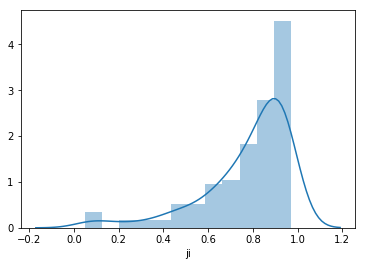

In [379]:
an_jc(df_v)

In [290]:
dataset = dataset_test
image_id = 314
(dataset.image_info[image_id]['path'])

'data/large/test/images/ISIC_0015368.jpg'

(-0.5, 511.5, 511.5, -0.5)

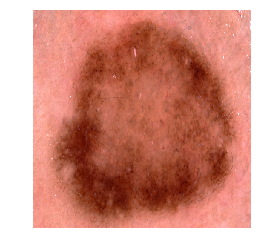

In [291]:
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, inference_config, image_id, use_mini_mask=False)
molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)

plt.imshow(image)
plt.axis("off")

(-0.5, 511.5, 511.5, -0.5)

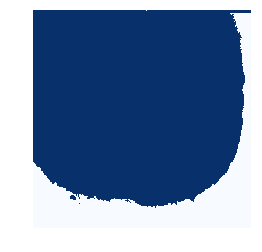

In [266]:
plt.imshow(gt_mask[:,:,0], cmap="Blues")
plt.axis("off")

In [267]:
# Run through model
results = model.detect([image], verbose=1)

# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    0.96194  float32
probs                    shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32
deltas                   shape: (1, 1000, 4, 4)       min:   -2.02699  max:    1.12672  float32
masks                    shape: (1, 100, 28, 28, 4)   min:    0.00000  max:    1.00000  float32
detections               shape: (1, 100, 6)           min:    0.00000  max:    1.00000  float32


In [268]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

2 Valid proposals out of 1000
2 Positive ROIs
[('BG', 998), ('nevus', 2)]


roi_bbox_specific        shape: (1000, 4)             min:   -2.02699  max:    1.01331  float32
refined_proposals        shape: (1000, 4)             min:   -3.00000  max:  509.00000  int32


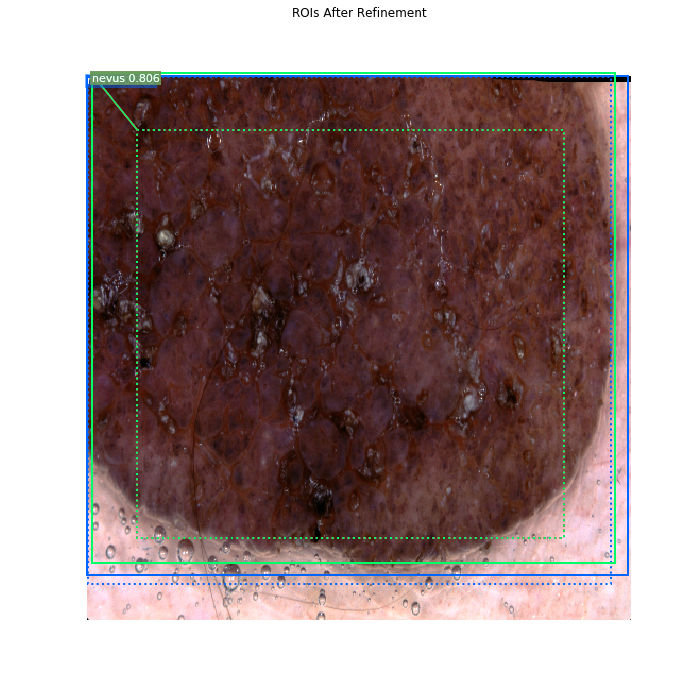

In [269]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement")

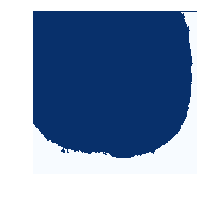

In [270]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

detections               shape: (1, 100, 6)           min:    0.00000  max:    1.00000  float32
masks                    shape: (1, 100, 28, 28, 4)   min:    0.00000  max:    1.00000  float32
1 detections: ['nevus']
det_mask_specific        shape: (1, 28, 28)           min:    0.00008  max:    1.00000  float32
det_masks                shape: (1, 512, 512)         min:    0.00000  max:    1.00000  bool


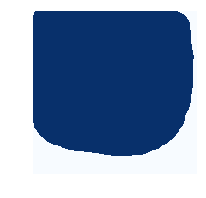

In [271]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

In [272]:
c = det_masks.shape[0]
image = image
gt_box = gt_bbox
gt_class_ids = gt_class_id
gt_mask = gt_mask
pred_box = det_boxes[0:c,:]
pred_class_id = det_class_ids
pred_score = np.array([mrcnn["detections"][0, 0, 5]])
pred_mask = det_masks.reshape([512,512,c])

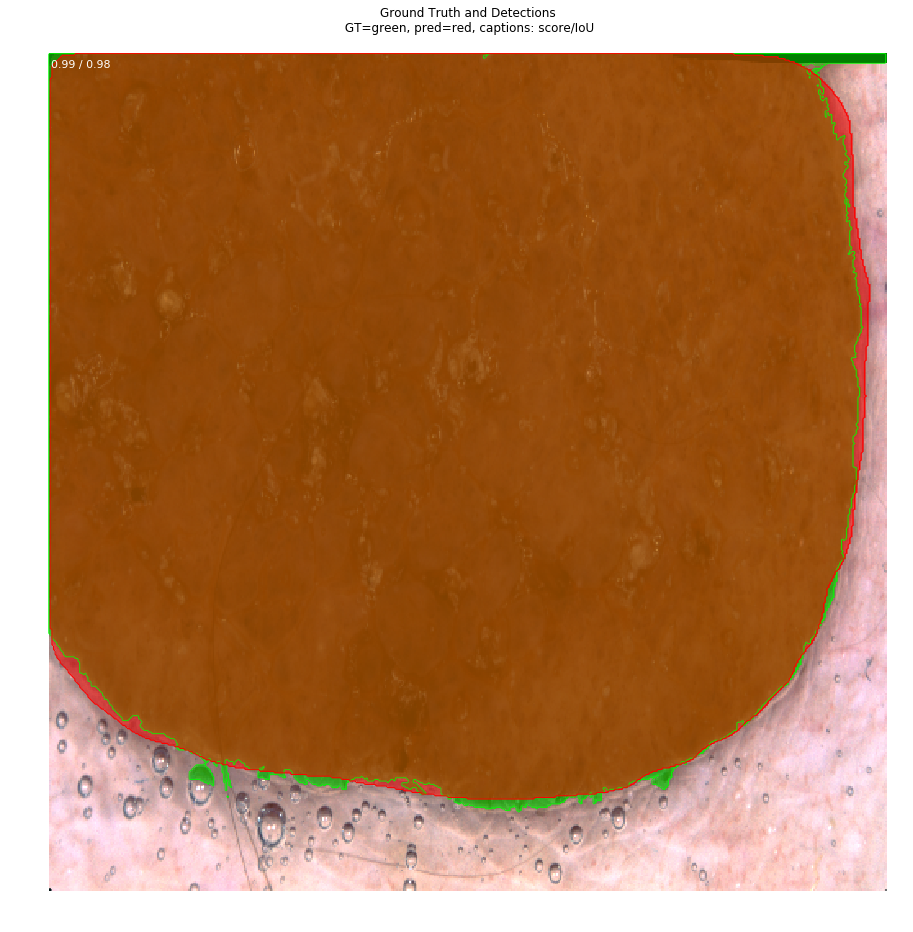

In [273]:
visualize.display_differences(image,
                        gt_box, gt_class_ids, gt_mask,
                        pred_box, pred_class_id, pred_score, pred_mask,
                        class_names=dataset.class_names, show_box=False)

In [149]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 512, 512, 3)      min:  -87.90000  max:  144.10001  float32
res4w_out                shape: (1, 32, 32, 1024)     min:    0.00000  max:   55.53674  float32
rpn_bbox                 shape: (1, 65472, 4)         min:   -7.47389  max:  152.14664  float32
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


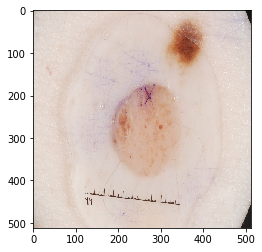

In [56]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

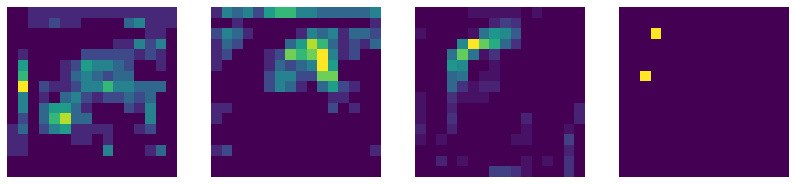

In [169]:
# Backbone feature map
display_images(np.transpose(activations["res4w_out"][0,:,:,:4], [2, 0, 1]))